In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data_path = join('./input', 'train.csv')
sub_data_path = join('./input', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [5]:
y = data['price']

del data['price']

In [6]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<Axes: >

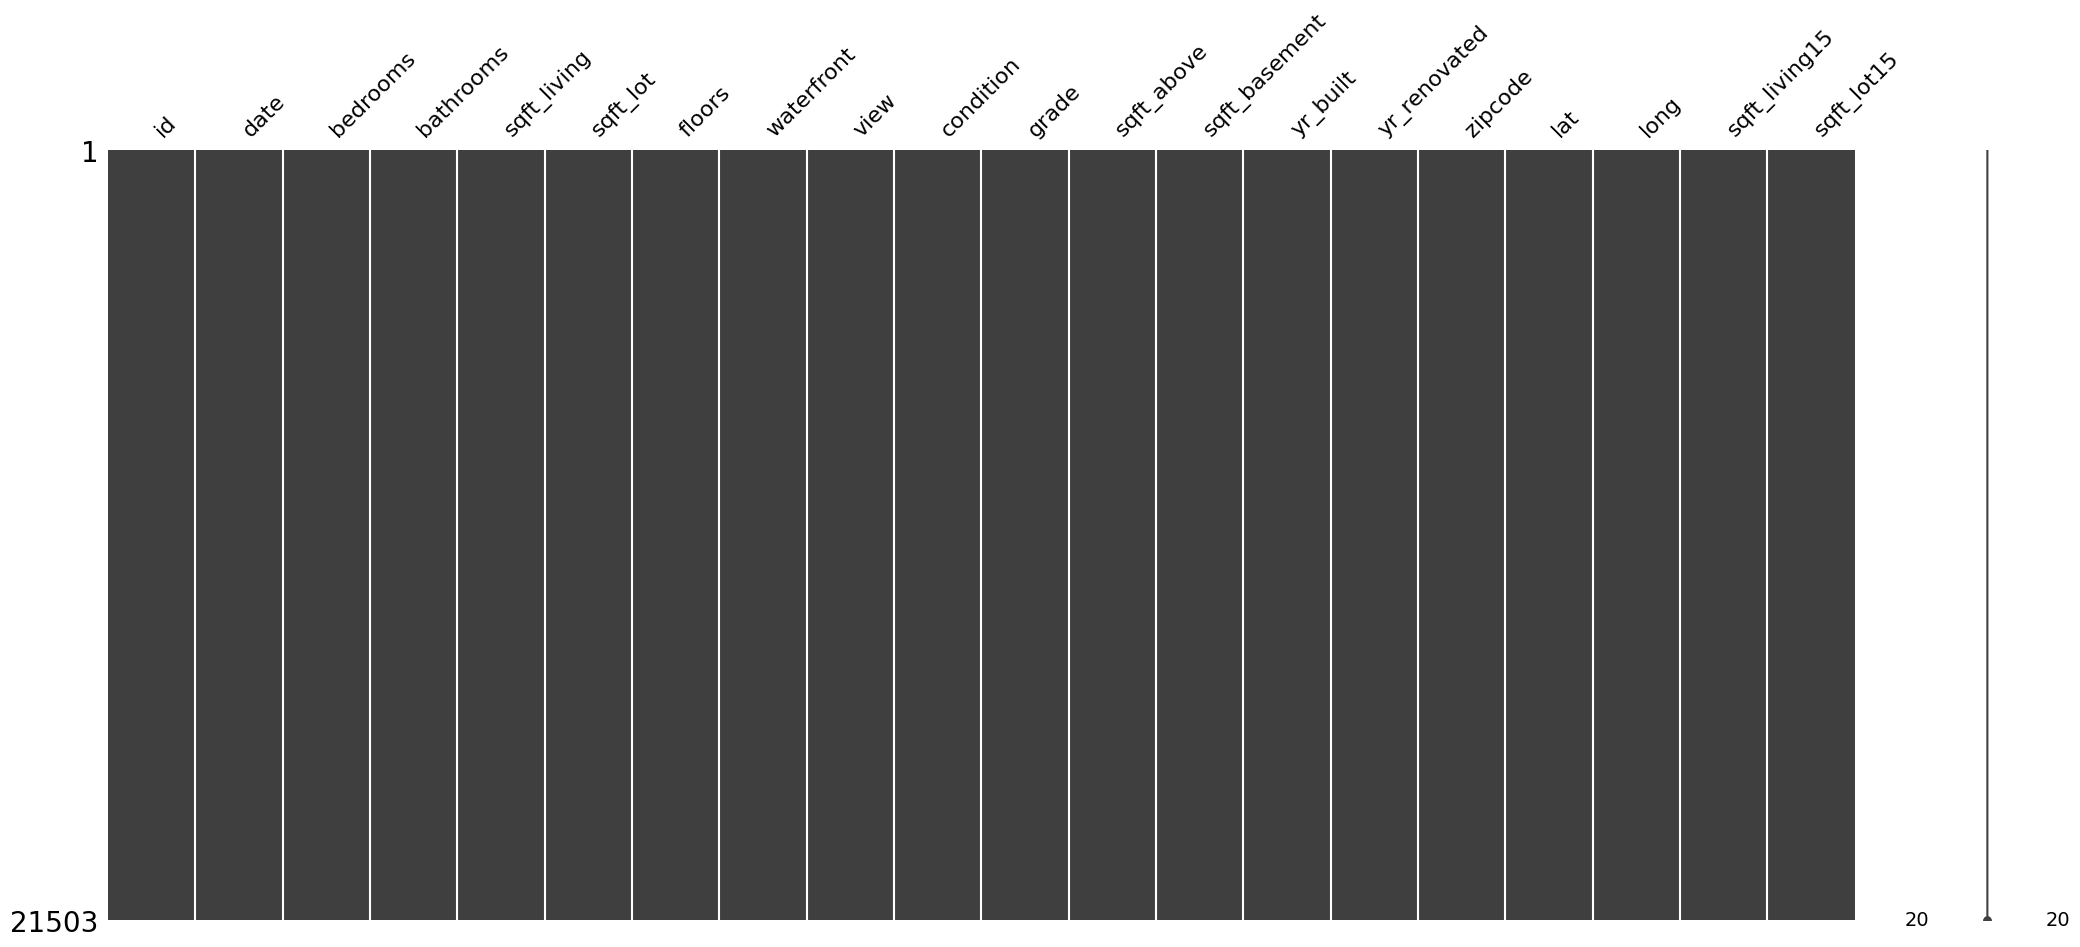

In [8]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [9]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [10]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

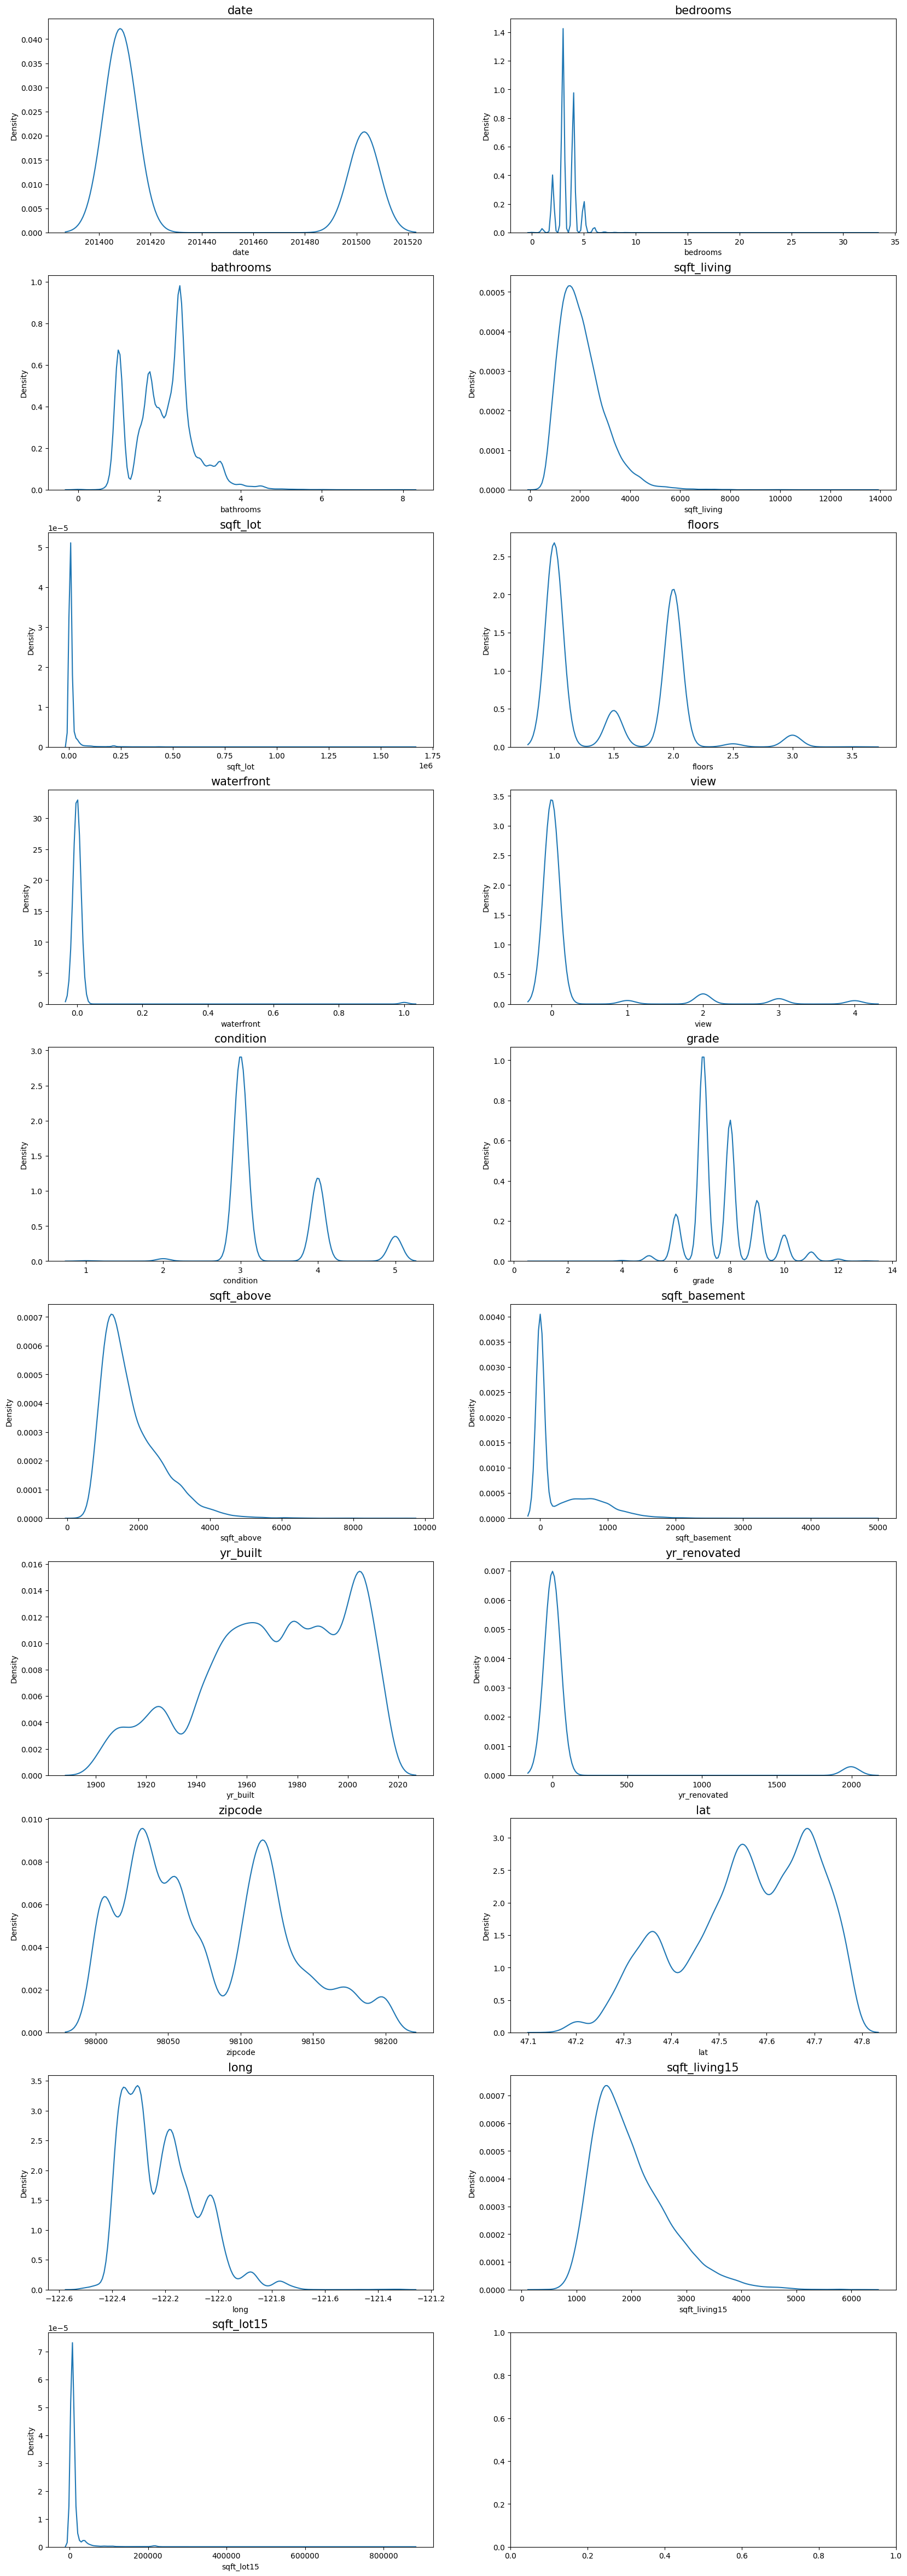

In [11]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

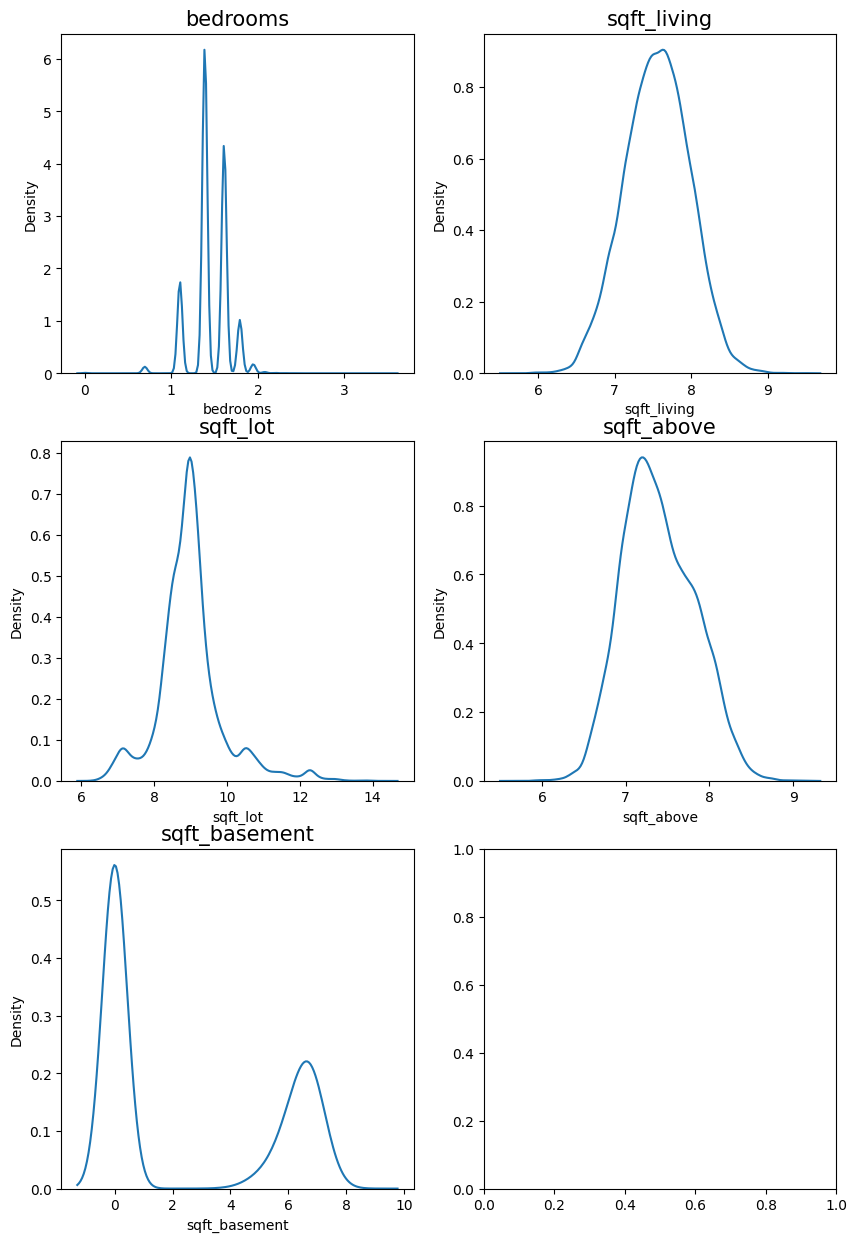

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [14]:
sub = data.iloc[train_len:, :].drop(['date'], axis=1)
x = data.iloc[:train_len, :].drop(['date'], axis=1)

In [15]:
x = pd.concat((x, y), axis=1)

## 3. 모델링
### AutoML을 통해 모델의 선정 및 하이퍼 파라미터 최적화를 진행

In [16]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor= TabularPredictor(label ='price').fit(train_data = x,presets='best_quality')
predictor.leaderboard(x, silent=True)

No path specified. Models will be saved in: "AutogluonModels\ag-20230323_091720\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230323_091720\"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22000
Train Data Rows:    15035
Train Data Columns: 18
Label Column: price
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (7700000.0, 78000.0, 540682.65314, 371524.66039)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to pre

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-428.563107,-295619.411365,0.235998,0.224998,0.013001,0.235998,0.224998,0.013001,1,True,2
1,LightGBMLarge_BAG_L1,-43470.963150,-128308.471045,2.297001,0.901001,56.678156,2.297001,0.901001,56.678156,1,True,11
2,XGBoost_BAG_L1,-46464.531868,-128750.666413,0.629002,0.291994,6.102000,0.629002,0.291994,6.102000,1,True,9
3,RandomForestMSE_BAG_L1,-48687.635932,-131879.558324,0.542999,0.529998,6.904824,0.542999,0.529998,6.904824,1,True,5
4,ExtraTreesMSE_BAG_L1,-49344.236656,-133618.258112,0.454997,0.580997,2.177001,0.454997,0.580997,2.177001,1,True,7
5,CatBoost_BAG_L1,-50032.408363,-116043.944608,0.157003,0.047997,111.828915,0.157003,0.047997,111.828915,1,True,6
6,ExtraTreesMSE_BAG_L2,-54181.809887,-113775.262232,12.417002,6.245992,333.268260,0.585001,0.575000,3.514513,2,True,17
7,RandomForestMSE_BAG_L2,-54243.620260,-111973.374986,12.335000,6.254992,350.807984,0.502999,0.584000,21.054237,2,True,15
8,WeightedEnsemble_L3,-54600.054743,-109906.052738,13.766991,6.526991,382.772303,0.004994,0.000000,0.356001,3,True,22
9,LightGBM_BAG_L1,-56393.201906,-122290.651193,1.509001,0.660002,16.201210,1.509001,0.660002,16.201210,1,True,4


### Make Submission

In [19]:
y_pred = predictor.predict(sub)

In [20]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [21]:
sub.to_csv('submission.csv', index=False)

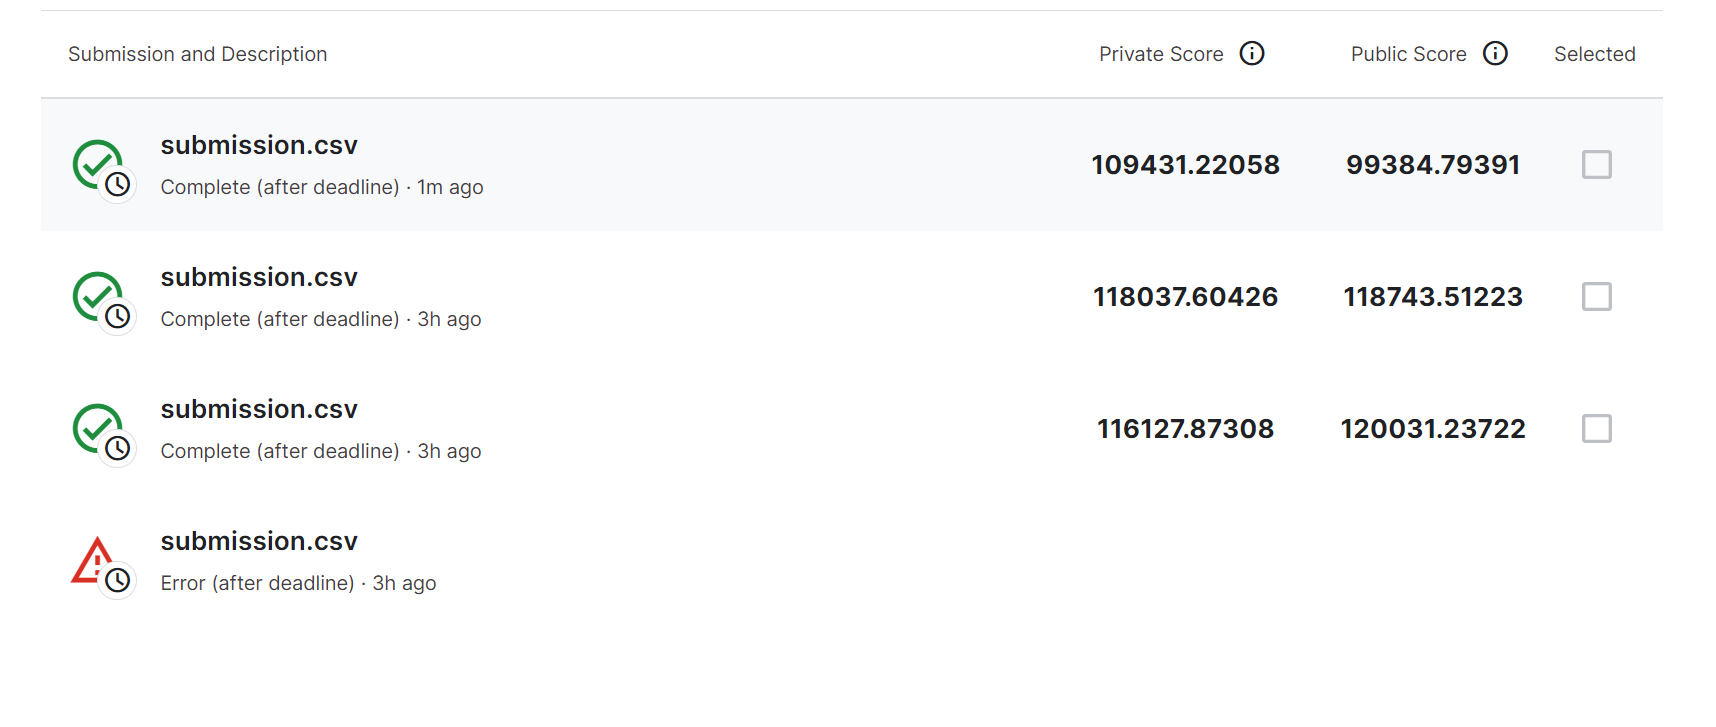